In [197]:
%install_ext https://raw.githubusercontent.com/SiggyF/notebooks/master/pep8_magic.py
%load_ext pep8_magic

Installed pep8_magic.py. To use it, type:
  %load_ext pep8_magic
The pep8_magic extension is already loaded. To reload it, use:
  %reload_ext pep8_magic


In [198]:
import numpy as np
import matplotlib.pyplot as plt  # for plots
import pandas as pd
from matplotlib import rc
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
import sklearn.linear_model as lm
import scipy as sc
from sklearn.utils import resample
import seaborn as sns
import os as macosx
import math
from os import mkdir, path
from IPython.display import display, Math, Latex
macosx.environ['PATH'] = macosx.environ['PATH'] + ':/usr/texbin'


# Exercice 1. (Estimateur de la variance (2 points))

le biais de cet estimateur est:
$$  BIAIS(\mathbf{V}_{\alpha}) = ((n-1)\alpha - 1) \sigma^2  $$

par ailleurs:
        $$ MSE(V_{\alpha}|\sigma^2) = BIAIS(V_{\alpha})^2 + Var(V_{\alpha}) $$

en conséquence
$$ MSE(V_{\alpha}|\sigma^2) = \sigma^4((n-1)^2\alpha^2+1) $$

la valeur alpha qui fournit le risque minimal est:
    $$ \alpha = \frac{1}{n-1} $$

# Exercice 2. (Lasso seuillé (13 pts))

In [199]:
from sklearn.datasets.mldata import fetch_mldata
test_data_home = tempfile.mkdtemp()
dataset_name = 'leukemia'
data = fetch_mldata(dataset_name)
X = data.data
y = data.target
X = X.astype(float)
y = y.astype(float)

1) Donner le nombre d’observations et de variables explicatives (features) de cette base de
données. Appliquer un pré-traitement afin que chaque colonne de X soit de variance empirique
égale à 1. (0.5 pt)

In [200]:
print "nombre d'observations: %s" % (X.shape[0])
print "nombre de variables explicatives: %s" % (X.shape[1])

nombre d'observations: 72
nombre de variables explicatives: 7129


In [201]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

2) Appliquer une analyse en composantes principales sur la matrice X, et visualiser les variables
explicatives en dimension d “ 1, puis d “ 2 en projetant sur les axes principaux qui
conviennent. (1 pt)

In [202]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_) 

[ 0.22568728  0.11655105]


In [203]:
## utilitaire pour le plot
def scatter(x, y, lbl):
    colors = np.random.rand(X.shape[0])
    s = 50
    plt.figure()
    plt.scatter(x, y, c=colors[:len(lbl)], s=50)

    for xi, yi, lbl in zip(x, y, lbl):
        plt.annotate(lbl, (xi, yi))
    plt.show()

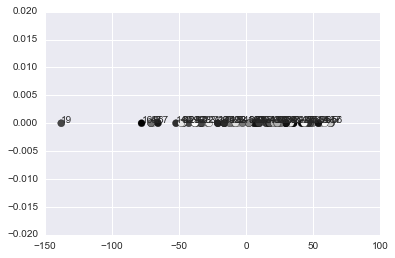

In [204]:
# visualisation sur l'axe principal
X_pca = pca.transform(X_scaled)
scatter(X_pca[:,0], np.zeros(X_pca.shape[0]), range(X_scaled.shape[0]))

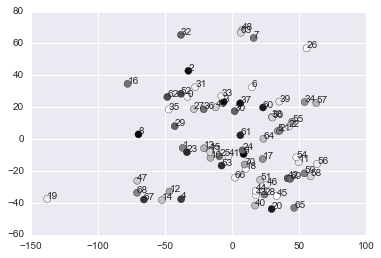

In [205]:
# visualisation sur les deux axes principaux
X_pca = pca.transform(X_scaled)
scatter(X_pca[:,0], X_pca[:,1], range(X_scaled.shape[1]))

3) Couper les données en deux ensembles : un pour l’entraînement pXtrain
, y
trainq et un pour
le test pXtest
, y
testq. On utilisera 80% des données pour l’entraînement (utiliser par exemple
la fonction cross_validation.train_test_split de sklearn). (0.5 pt)

In [206]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

4) Trouver mathématiquement λprime en fonction de λ

$$ \lambda^{'} = \frac{\lambda}{n} $$

5) Utiliser LassoCV sur X_train, y_train

In [207]:
from sklearn.linear_model import LassoCV
model = LassoCV(fit_intercept= False).fit(X_train, y_train)
print "score R^2 de prédiction sur le jeu de test: %s" % (model.score(X_test, y_test))
print "erreur quadratique sur le jeu de test: %s" % (np.linalg.norm(y_test - model.predict(X_test),2)**2)

score R^2 de prédiction sur le jeu de test: 0.564201486601
erreur quadratique sur le jeu de test: 5.81064684532


6) Coder la méthode suivante :

je choisis d'implémenter une classe LassoSeuilleLasso qui hérite de Lasso de sklearn. la fonction lassoSeuille est incluse dans la classe.

In [208]:
class LassoSeuilleLasso(lm.Lasso):
    
    def __init__(self, tau=1e-4 ,alpha=1.0, fit_intercept=True, normalize=False,
                 precompute=False, copy_X=True, max_iter=1000,
                 tol=1e-4, warm_start=False, positive=False,
                 random_state=None, selection='cyclic'):
        super(LassoSeuilleLasso, self).__init__(
            alpha=alpha, fit_intercept=fit_intercept, normalize=normalize,
                 precompute=precompute, copy_X=copy_X, max_iter=max_iter,
                 tol=tol, warm_start=warm_start, positive=positive,
                 random_state=random_state, selection=selection)
        self.tau = tau
        
    
    def lassoSeuille(self, X, y):    
        """lassoSeuille.
        Parameters
        -----------
        X : ndarray or scipy.sparse matrix, (n_samples, n_features)
            Data
        y : ndarray, shape (n_samples,) or (n_samples, n_targets)
            Target
        Input: alpha, tau
        Notes
        -----
        """

        n, p = X.shape
        setSupport = []
        super(LassoSeuilleLasso, self).fit(X, y)
        
        for i in range(0,p):
            if abs(self.coef_[i]) > self.tau:
                setSupport.append(i)
        if len(setSupport) > 0:       
            X_support = X[:,list(setSupport)]
            linreg = lm.LinearRegression(fit_intercept=self.fit_intercept,
                                     normalize=self.normalize, copy_X=self.copy_X)
            linreg.fit(X_support,y[:,np.newaxis])
        else:
            return 0, 0, []
        
        return linreg.coef_, linreg.intercept_, list(setSupport)

    def fit(self, X, y, check_input=True):
        """Fit model with coordinate descent.
        Parameters
        -----------
        X : ndarray or scipy.sparse matrix, (n_samples, n_features)
            Data
        y : ndarray, shape (n_samples,) or (n_samples, n_targets)
            Target
        Notes
        -----
        """
        coef, intercept, support = self.lassoSeuille(X, y)
        self.coef_ = np.zeros(len(self.coef_))
        self.coef_[support] = coef
        self.intercept_ = intercept 
        # return self for chaining fit and predict calls
        return self

In [209]:
model_seuille = LassoSeuilleLasso(alpha = model.alpha_, tau = 1e-4, fit_intercept= False)
model_seuille.fit(X_train, y_train)
model_seuille.score(X_test, y_test)
print "score R^2 de prédiction sur le jeu de test: %s" % (model_seuille.score(X_test, y_test))
print "erreur quadratique sur le jeu de test: %s" % (np.linalg.norm(y_test - model_seuille.predict(X_test),2)**2)

score R^2 de prédiction sur le jeu de test: 0.680438085531
erreur quadratique sur le jeu de test: 4.26082552625


7) Proposer et calculer deux estimateurs σˆ de l’écart type du bruit. 

In [210]:
#estimateur de sigma_hat avec biais
sigma_hat_b = np.linalg.norm(y_train-model.predict(X_train),2)/n
print "estimateur avec biais: %s" % sigma_hat_b
#estimateur de sigma_hat sans biais
sigma_hat = np.linalg.norm(y_train-model.predict(X_train),2)/(n-np.rank(X_train))
print "estimateur sans biais: %s" % sigma_hat

estimateur avec biais: 0.0506830689278
estimateur sans biais: 0.0521311566114


8) Écrire une procédure de validation croisée pour la procédure “Lasso Seuillé”

In [211]:
from sklearn import grid_search
clf_l = LassoSeuilleLasso(alpha=0.1, fit_intercept= False)
n, p = X.shape
tau = sigma_hat*np.sqrt(np.log(p/n))
print "valeur optimal de tau %s :" % tau
parameters = {'alpha':  [ 10**i for i in range (-5,5)], 'tau': [0.01, 0.05, 0.1, 0.15, 0.20]}
gs_l = grid_search.GridSearchCV(clf_l, param_grid = parameters, cv=5)
gs_l.fit(X_train, y_train)
gs_l.score(X_train,y_train)
#gs_l.get_params()
print "meilleur estimateur: %s " % (gs_l.best_estimator_)
print "score R^2 de prédiction sur le jeu de test: %s" % (gs_l.score(X_test, y_test))
print "erreur quadratique sur le jeu de test: %s" % (np.linalg.norm(y_test - gs_l.predict(X_test),2)**2)

valeur optimal de tau 0.111749549782 :
meilleur estimateur: LassoSeuilleLasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
         normalize=False, positive=False, precompute=False,
         random_state=None, selection='cyclic', tau=0.1, tol=0.0001,
         warm_start=False) 
score R^2 de prédiction sur le jeu de test: 0.594900779612
erreur quadratique sur le jeu de test: 5.4013229385


9) Comparer l’erreur de prédiction obtenue sur la partie “test” pour : a) le “Lasso Seuillé” avec
validation croisée (de la question précédente) b) le LassoCV et c) l’estimateur des moindres
carrées, toujours sans intercept. (0.5 pts)

In [212]:
# création du modèle de régréssion linéaire standard
model_l = lm.LinearRegression(fit_intercept=False)
model_l.fit(X_train, y_train)
model_l.score(X_test, y_test)



-1.8139429334750967

In [213]:
# création du tableau de comparaison
models = [gs_l, model, model_l]
df = pd.DataFrame(columns=["Lasso Seuillé", "LassoCV", "LinearRegression"])
df.loc['score'] = list(map(lambda x: x.score(X_test, y_test), models))
df.loc['MSE'] = list(map(lambda x: np.linalg.norm(y_test-x.predict(X_test),2)**2, models))
df

,Lasso Seuillé,LassoCV,LinearRegression
score,0.594901,0.564201,-1.813943
MSE,5.401323,5.810647,37.519239


10) Tester une autre méthode de votre choix pour essayer d’améliorer la prédiction. (0.5 pt)

on choisit de tester avec la méthode RidgeCV

In [214]:
from sklearn.linear_model import RidgeCV
ridgecv = RidgeCV(fit_intercept=False)
ridgecv.fit(X_train, y_train)
print "score R^2 de prédiction sur le jeu de test: %s" % (ridgecv.score(X_test, y_test))
print "erreur quadratique sur le jeu de test: %s" % (np.linalg.norm(y_test - ridgecv.predict(X_test),2)**2)

score R^2 de prédiction sur le jeu de test: -1.74842523831
erreur quadratique sur le jeu de test: 36.6456698441


11) Reprendre l’ensemble des comparaisons précédentes, mais cette fois en tenant compte de
l’intercept dans votre démarche. (0.5 pts)

In [215]:

modelLCV = LassoCV(fit_intercept= True).fit(X_train, y_train)
clf_l = LassoSeuilleLasso(alpha=0.1, fit_intercept= True)
parameters = {'alpha':  [ 10**i for i in range (-5,5)], 'tau': [0.01, 0.05, 0.1, 0.15, 0.20]}
gs_l = grid_search.GridSearchCV(clf_l, param_grid = parameters, cv=5).fit(X_train, y_train)
model_l = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
models_w_intercept = [gs_l, modelLCV, model_l]


In [216]:
df2 = pd.DataFrame(columns=["Lasso Seuillé", "LassoCV", "LinearRegression"])
df2.loc['score'] = list(map(lambda x: x.score(X_test, y_test), models_w_intercept))
df2.loc['MSE'] = list(map(lambda x: np.linalg.norm(y_test-x.predict(X_test),2)**2, models_w_intercept))
df2

,Lasso Seuillé,LassoCV,LinearRegression
score,0.729427,0.762642,0.706204
MSE,3.607636,3.164777,3.917279


12) Bonus : Comparer les performances sur la partie test, de LassoCV (en le modifiant pour retourner
une prédiction valant soit 1 soit ´1) contre LogisticRegressionCV. On utilisera ici
l’erreur 0{1 (i.e., la proportion d’erreurs de “classe” faites) comme mesure de performance.
(1 pt)

In [217]:
predict_lasso = modelLCV.predict(X_test)

In [218]:
predict_lasso_class = np.array(list(map(lambda x: 1 if x>=0 else -1, predict_lasso)))

In [219]:
from sklearn.linear_model import LogisticRegressionCV
LogRCV = LogisticRegressionCV().fit(X_train, y_train)


In [220]:
from sklearn.metrics import f1_score
print "erreur 0/1 LassoCV : %s" % f1_score(y_test, predict_lasso_class)
print "erreur 0/1 Logistic Regression : %s" % f1_score(y_test, LogRCV.predict(X_test))


erreur 0/1 LassoCV : 0.952380952381
erreur 0/1 Logistic Regression : 1.0
